<a href="https://colab.research.google.com/github/tejasspawar/face-mask-detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 102kB 7.6MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=20a3a3d9b401c2f36ac76f4f7e7bdfc8b305905afca0d7f29bd72ec8166f2729
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Creating X and y

## Sample of original image

In [ ]:
path = '/content/drive/MyDrive/Face mask data/mask/1.png'
img = cv2.imread(path)
img.shape

(96, 96, 3)

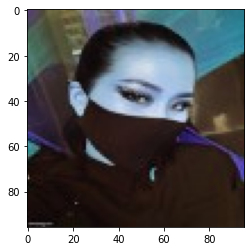

In [ ]:
plt.imshow(img)

## Appending With mask images

In [ ]:
 X = []
 X_scaled = []
 y = []
 for i in range(1,595):
   try:
     path = '/content/drive/MyDrive/Face mask data/mask/{}.png'.format(i)
     img = cv2.imread(path)    
     X.append(img)
     X_scaled.append(img/255)
     y.append(1)
   except:
     pass


## Appending without mask images

In [ ]:
for i in range(1,617):
   try:
     path = '/content/drive/MyDrive/Face mask data/without_mask/{}.png'.format(i)
     img = cv2.imread(path)    
     X.append(img)
     X_scaled.append(img/255)
     y.append(0)
   except:
     pass  

# Train-Test split

In [ ]:
X = np.array(X)
X_scaled = np.array(X_scaled)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0, stratify=y)

# Training CNN

In [ ]:
cnn1 = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [ ]:
cnn1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn1.fit(X_train, y_train, epochs=5)

Epoch 1/5
33/33 [==============================] - 30s 19ms/step - loss: 0.5976 - accuracy: 0.6917
Epoch 2/5
33/33 [==============================] - 0s 15ms/step - loss: 0.3896 - accuracy: 0.8468
Epoch 3/5
33/33 [==============================] - 0s 14ms/step - loss: 0.2920 - accuracy: 0.8907
Epoch 4/5
33/33 [==============================] - 0s 14ms/step - loss: 0.2686 - accuracy: 0.8888
Epoch 5/5
33/33 [==============================] - 0s 14ms/step - loss: 0.2463 - accuracy: 0.9054


# Classification report of test data


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = cnn1.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.94      0.84        93
           1       0.91      0.71      0.80        89

    accuracy                           0.82       182
   macro avg       0.84      0.82      0.82       182
weighted avg       0.84      0.82      0.82       182



# Testing


In [ ]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

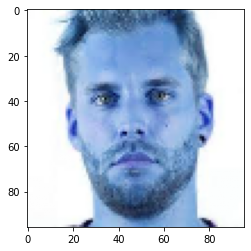

In [ ]:
plt.imshow(img_wm)

In [ ]:
# Not Wearing mask
if cnn1.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


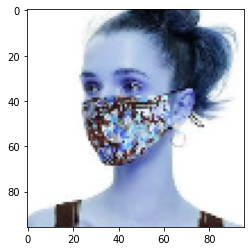

In [ ]:
plt.imshow(img_m)

In [ ]:
# Wearing mask
if cnn1.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask


# Training CNN with Data Augmentaion


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(96, 
                                                              96,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

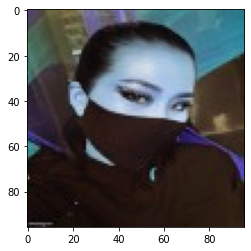

In [ ]:
# Previous
plt.imshow(X_scaled[0])

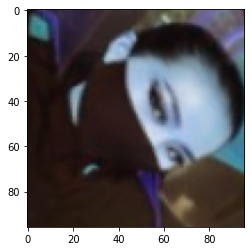

In [ ]:
# After augmentation
plt.imshow(data_augmentation(X_scaled)[0])

In [ ]:
cnn2 = models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [ ]:
cnn2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn2.fit(X_train, y_train, epochs=5)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 0.7378 - accuracy: 0.5317
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 0.5707 - accuracy: 0.7083
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 0.4653 - accuracy: 0.8000
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 0.3424 - accuracy: 0.8507
Epoch 5/5
33/33 [==============================] - 1s 17ms/step - loss: 0.3369 - accuracy: 0.8527


# Classification report of test data


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = cnn2.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.95      0.87        93
           1       0.93      0.76      0.84        89

    accuracy                           0.86       182
   macro avg       0.87      0.86      0.86       182
weighted avg       0.87      0.86      0.86       182



# Testing

In [ ]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

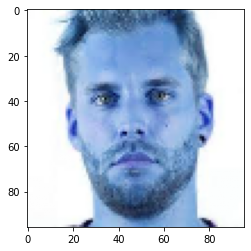

In [ ]:
plt.imshow(img_wm)

In [ ]:
# Not Wearing mask
if cnn2.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


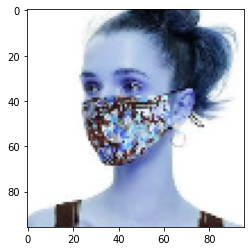

In [ ]:
plt.imshow(img_m)

In [ ]:
# Wearing mask
if cnn2.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask


# Training CNN using keras tuner

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(96,96,3)
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist Fashion")

In [ ]:
tuner_search.search(X_train,y_train,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.4757281541824341

Best val_accuracy So Far: 0.7961165308952332
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                991296    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
29/29 [==============================] - 1s 27ms/step - loss: 0.2694 - accuracy: 0.8970 - val_loss: 0.3656 - val_accuracy: 0.8738
Epoch 5/10
29/29 [==============================] - 1s 23ms/step - loss: 0.2222 - accuracy: 0.9176 - val_loss: 0.3358 - val_accuracy: 0.8835
Epoch 6/10
29/29 [==============================] - 1s 22ms/step - loss: 0.1693 - accuracy: 0.9382 - val_loss: 0.3858 - val_accuracy: 0.8350
Epoch 7/10
29/29 [==============================] - 1s 22ms/step - loss: 0.1453 - accuracy: 0.9458 - val_loss: 0.3598 - val_accuracy: 0.8738
Epoch 8/10
29/29 [==============================] - 1s 22ms/step - loss: 0.1078 - accuracy: 0.9599 - val_loss: 0.3741 - val_accuracy: 0.8447
Epoch 9/10
29/29 [==============================] - 1s 22ms/step - loss: 0.0984 - accuracy: 0.9675 - val_loss: 0.3961 - val_accuracy: 0.8641
Epoch 10/10
29/29 [==============================] - 1s 22ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.4978 - val_accuracy: 0.8738


# Classification report of test data


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90        93
           1       0.95      0.82      0.88        89

    accuracy                           0.89       182
   macro avg       0.90      0.89      0.89       182
weighted avg       0.90      0.89      0.89       182



# Testing

In [ ]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

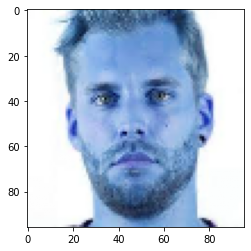

In [ ]:
plt.imshow(img_wm)

In [ ]:
# Not Wearing mask
if model.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


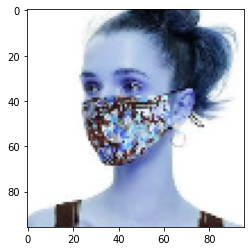

In [ ]:
plt.imshow(img_m)

In [ ]:
# Wearing mask
if model.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask
